In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import tfim_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

# We test the case when R^K/p^K_min\approx 1. Here we set p_0=0.21, p_1=0.6 (R^k=0.19, p^K_min=0.21)

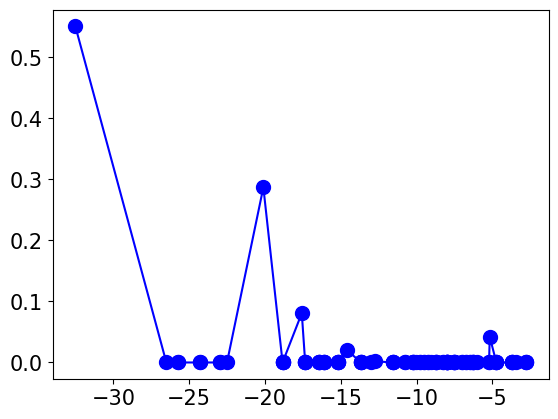

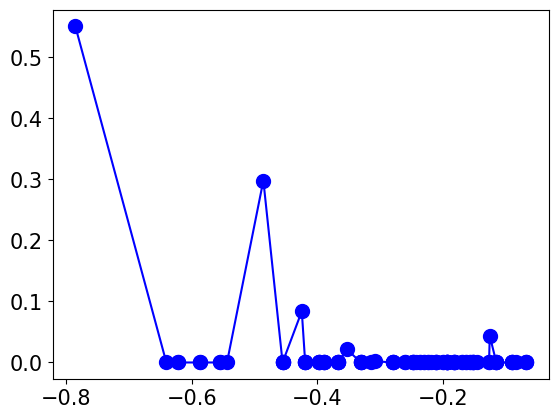

In [2]:
num_sites = 8
J = 1.0
g = 4.0

num_eigenstates_max = 100

ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = tfim_1d.generate_ham(num_sites, J, g)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0]])

plt.plot(spectrum, population,'b-o');plt.show()


In [3]:
def spectrum_organize(Output_QCELS): #combine opposite r but same \theta
    dis_threshold=0.01
    L=len(Output_QCELS)
    L=int(L/3)
    index_list=np.zeros(L, dtype='float')
    weight_rearrange=np.zeros(L, dtype='complex')
    indicator=np.zeros(L, dtype='float')
    for l in range(L): #combine eigenvalues with oppposite weight
        if indicator[l]==0:
           weight_rearrange[l]=Output_QCELS[3*l]+1j*Output_QCELS[3*l+1]
           fix_energy_check=Output_QCELS[3*l+2]
           for j in range(l+1,L): 
               if np.abs(Output_QCELS[3*j+2]-fix_energy_check)<dis_threshold:
                  weight_rearrange[l]+=Output_QCELS[3*j]+1j*Output_QCELS[3*j+1]
                  indicator[j]=1
        indicator[l]=1
        weight_rearrange[l]=np.abs(weight_rearrange[l])
    index_list=sorted(range(L),key= lambda k:weight_rearrange[k], reverse=True)
    dominant_energy=np.zeros(L, dtype='float')
    for l in range(L):
        dominant_energy[l]=Output_QCELS[3*index_list[l]+2]
    return dominant_energy

In [4]:
p0_array = np.array([0.21], dtype='float') #initial overlap with the first eigenvector
p1_array=np.array([0.6], dtype='float') #initial overlap with the second eigenvector
N_test_QCELS = 10  #number of different circuit depths for QCELS test
N_QPE = 10  #number of different circuit depths for QCELS QPE test
#Generate T_max list
T_gap = 115
T_list_QCELS = T_gap*(2**(np.arange(N_test_QCELS)))### circuit depth for QCELS
T_list_QPE = T_gap*(2**(np.arange(N_QPE)))###circuit depth for QPE
#Array of error
err_QCELS_ground=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QCELS_dominant=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE_ground=np.zeros((len(p0_array),len(T_list_QPE)))
#Array of maximal running time
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
#Array of total running time
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
Navg = 5 #number of repetitions
#Failure threshold
err_threshold=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    p1=p1_array[a1]
    for n_test in range(Navg):
        print("For p0,p1=",[p0,p1],"For N_test=",n_test+1)
        #Generate initial state with certain overlap
        #random energy perturbation to avoid special case 
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0,p1])
        spectrum=spectrum+np.random.uniform(-1,1)*0.05
        #------------------QCELS-Gaussian-----------------
        gamma=1
        K=2
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            T_0 = 10/(spectrum[1]-spectrum[0])
            NT_0 = 3000 #N_0
            NT = 2000 #N_{1:l}
            dominant_energy_estimate=np.zeros(K)
            Output_QCELS, cost_list_QCELS_this_run, max_T_QCELS_this_run = \
                    qcels_multimodal(spectrum, population, T_0, T, NT_0, NT, gamma, K, spectrum[0:2])#QCELS with time T
            dominant_energy_estimate=np.sort(spectrum_organize(Output_QCELS))
            err_QCELS_ground_this_run = np.abs(dominant_energy_estimate[0] - spectrum[0])
            err_QCELS_dominant_this_run = np.linalg.norm(dominant_energy_estimate - spectrum[0:2],np.inf)
            err_QCELS_ground[a1,ix] = err_QCELS_ground[a1,ix]+np.abs(err_QCELS_ground_this_run)
            err_QCELS_dominant[a1,ix] = err_QCELS_dominant[a1,ix]+np.abs(err_QCELS_dominant_this_run)
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this_run)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this_run
            if np.abs(err_QCELS_dominant_this_run)>err_threshold: #failure case
                print('QCELS fail')
#        # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_QPE_this_run = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE_ground[a1,ix] = err_QPE_ground[a1,ix]+np.abs(err_QPE_this_run)
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    err_QCELS_dominant[a1,:] = err_QCELS_dominant[a1,:]/Navg
    err_QCELS_ground[a1,:] = err_QCELS_ground[a1,:]/Navg
    err_QPE_ground[a1,:] = err_QPE_ground[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg

For p0,p1= [0.21, 0.6] For N_test= 1
For p0,p1= [0.21, 0.6] For N_test= 2
For p0,p1= [0.21, 0.6] For N_test= 3
For p0,p1= [0.21, 0.6] For N_test= 4
For p0,p1= [0.21, 0.6] For N_test= 5


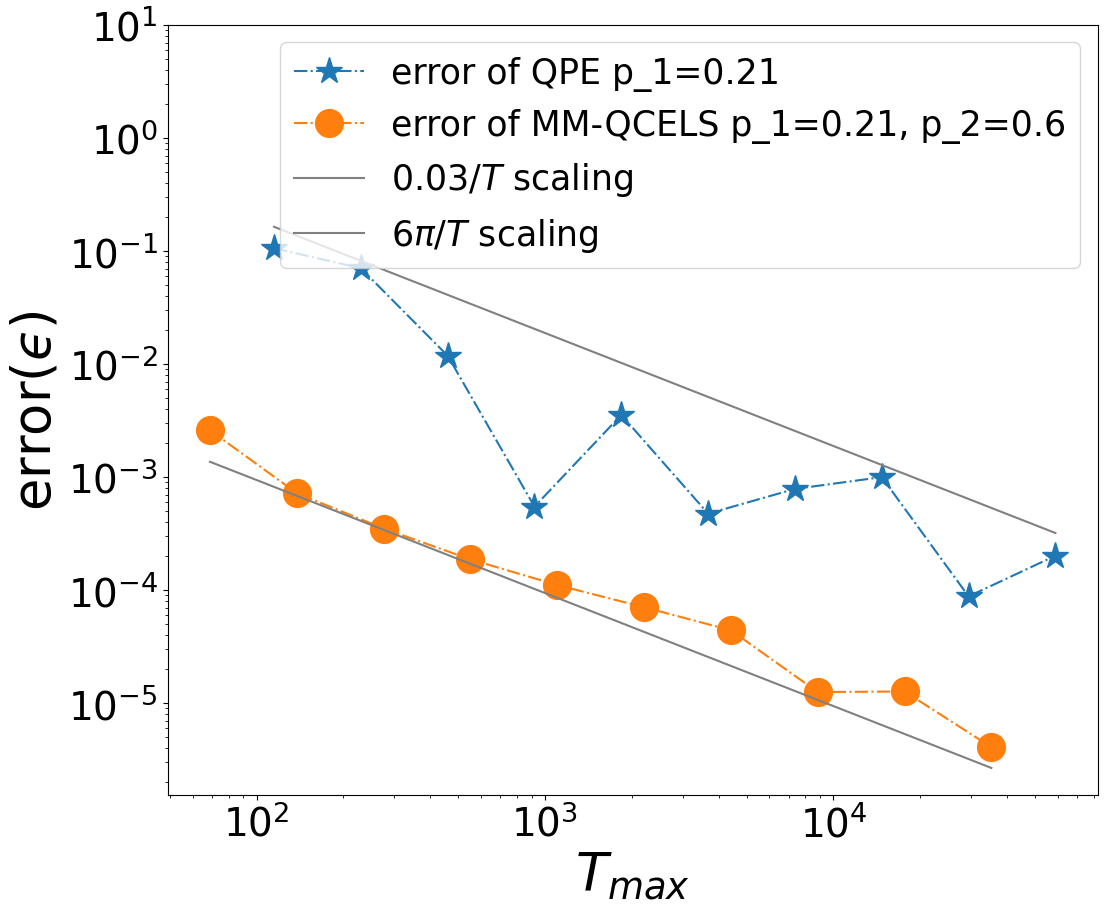

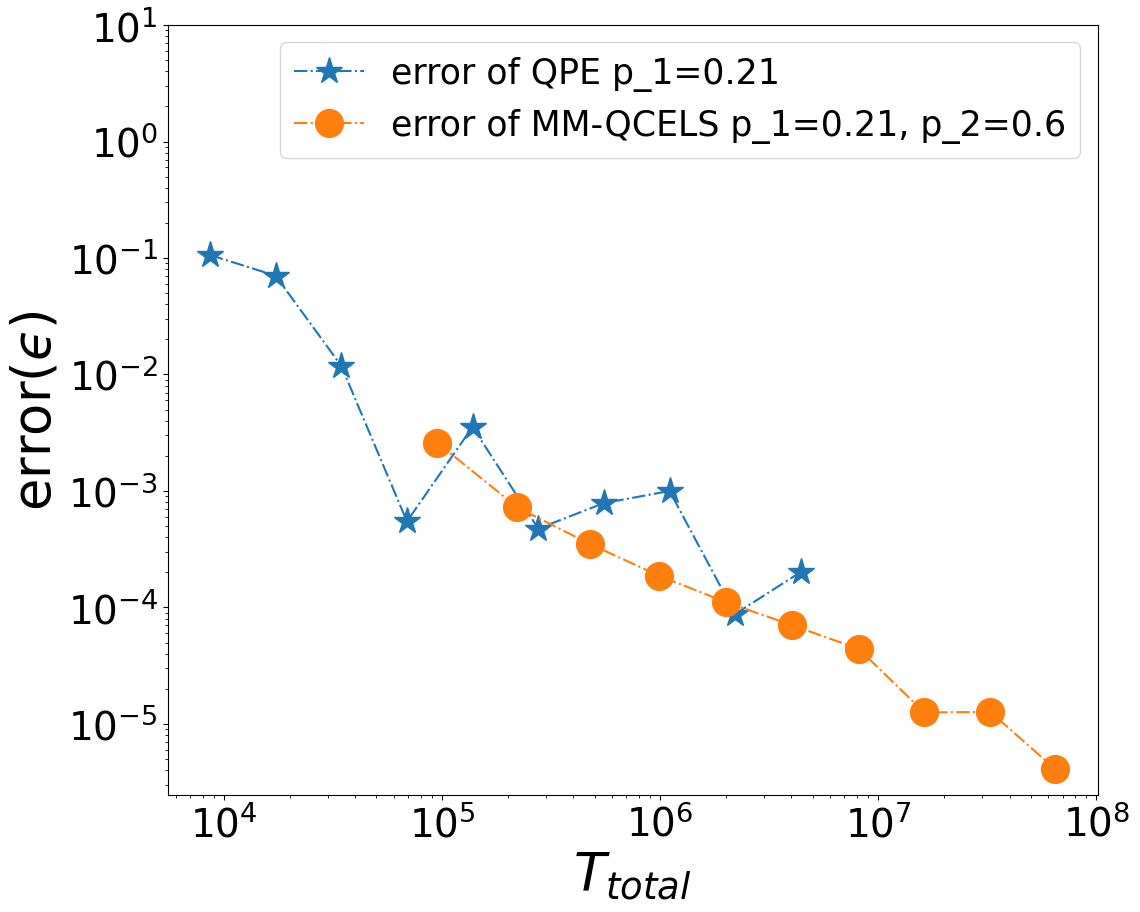

In [5]:
fig3=plt.figure(figsize=(12,10))
plt.plot(T_list_QPE,err_QPE_ground[0,:],linestyle="-.",marker="*",markersize=20,
         label="error of QPE p_1={}".format(p0_array[0]))
plt.plot(max_T_QCELS[0,:],err_QCELS_ground[0,:],linestyle="-.",marker="o",markersize=20,
         label="error of MM-QCELS p_1={}, p_2={}".format(p0_array[0],p1_array[0]))
plt.plot(max_T_QCELS[0,:],0.03*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.03/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)
plt.savefig('TFIM_depth_8_ground_small_p_0.pdf')
fig4=plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QPE[0,:],err_QPE_ground[0,:],linestyle="-.",marker="*",markersize=20,
         label="error of QPE p_1={}".format(p0_array[0]))
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS_ground[0,:],linestyle="-.",marker="o",markersize=20,
         label="error of MM-QCELS p_1={}, p_2={}".format(p0_array[0],p1_array[0]))
plt.xlabel("$T_{total}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38) 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)
plt.savefig('TFIM_cost_8_ground_small_p_0.pdf')
plt.show()

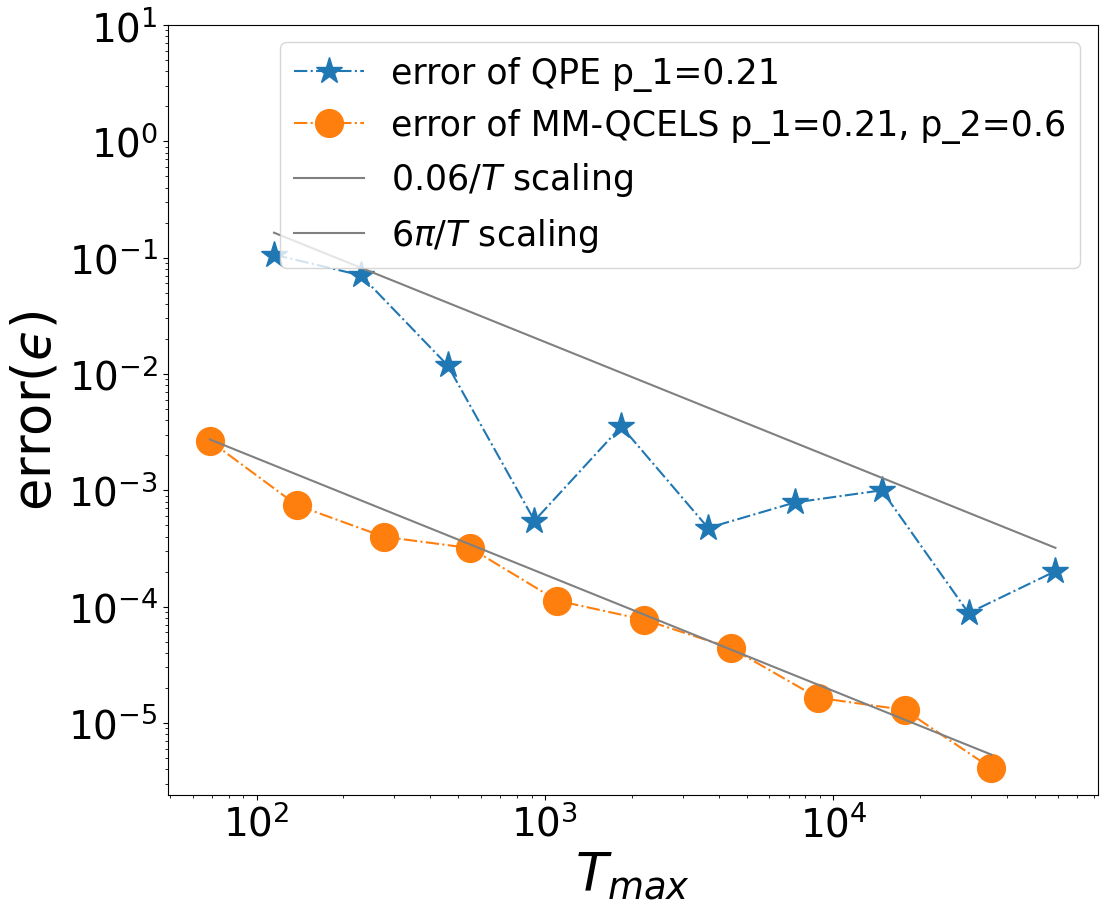

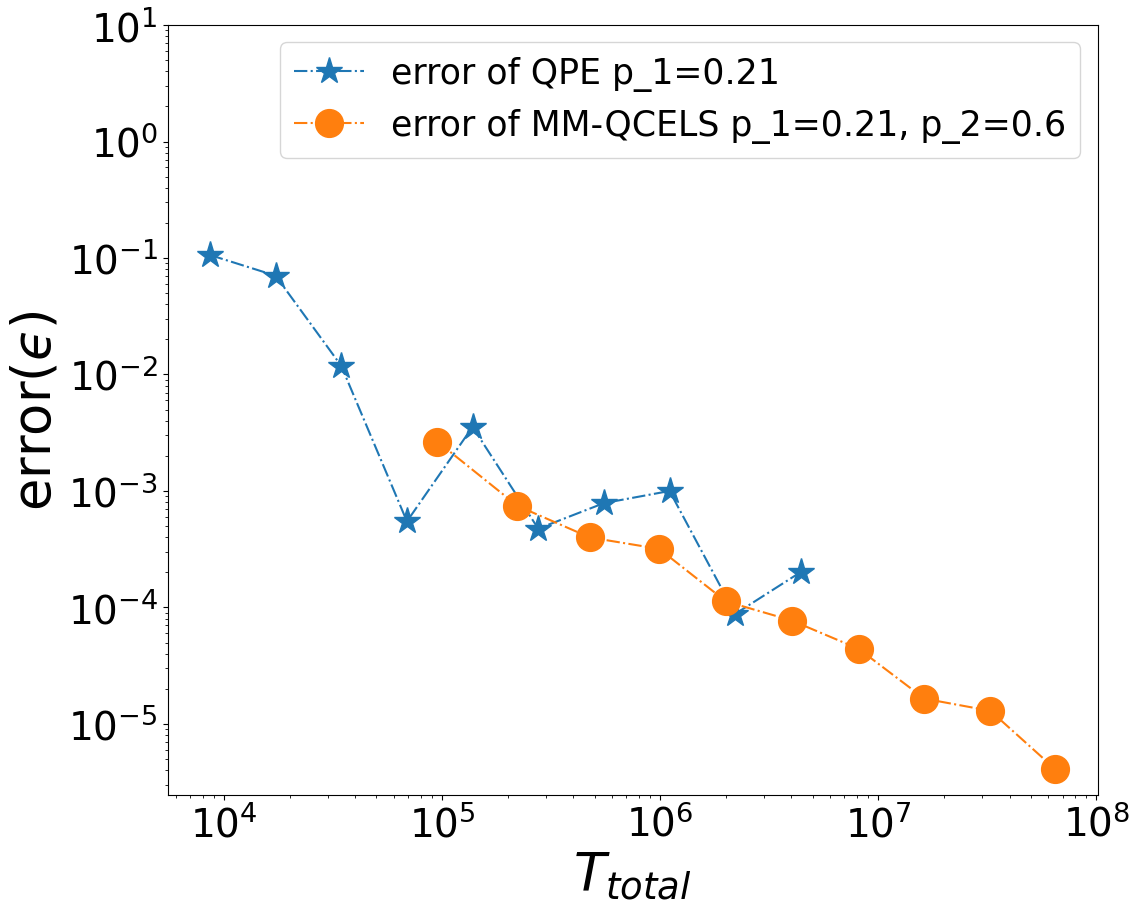

In [6]:
fig1=plt.figure(figsize=(12,10))
plt.plot(T_list_QPE,err_QPE_ground[0,:],linestyle="-.",marker="*",markersize=20,
         label="error of QPE p_1={}".format(p0_array[0]))
plt.plot(max_T_QCELS[0,:],err_QCELS_dominant[0,:],linestyle="-.",marker="o",markersize=20,
         label="error of MM-QCELS p_1={}, p_2={}".format(p0_array[0],p1_array[0]))
plt.plot(max_T_QCELS[0,:],0.06*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.06/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)
plt.savefig('TFIM_depth_8_all_small_p_0.pdf')
fig2=plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QPE[0,:],err_QPE_ground[0,:],linestyle="-.",marker="*",markersize=20,
         label="error of QPE p_1={}".format(p0_array[0]))
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS_dominant[0,:],linestyle="-.",marker="o",markersize=20,
         label="error of MM-QCELS p_1={}, p_2={}".format(p0_array[0],p1_array[0]))
plt.xlabel("$T_{total}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38) 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)
plt.savefig('TFIM_cost_8_all_small_p_0.pdf')
plt.show()

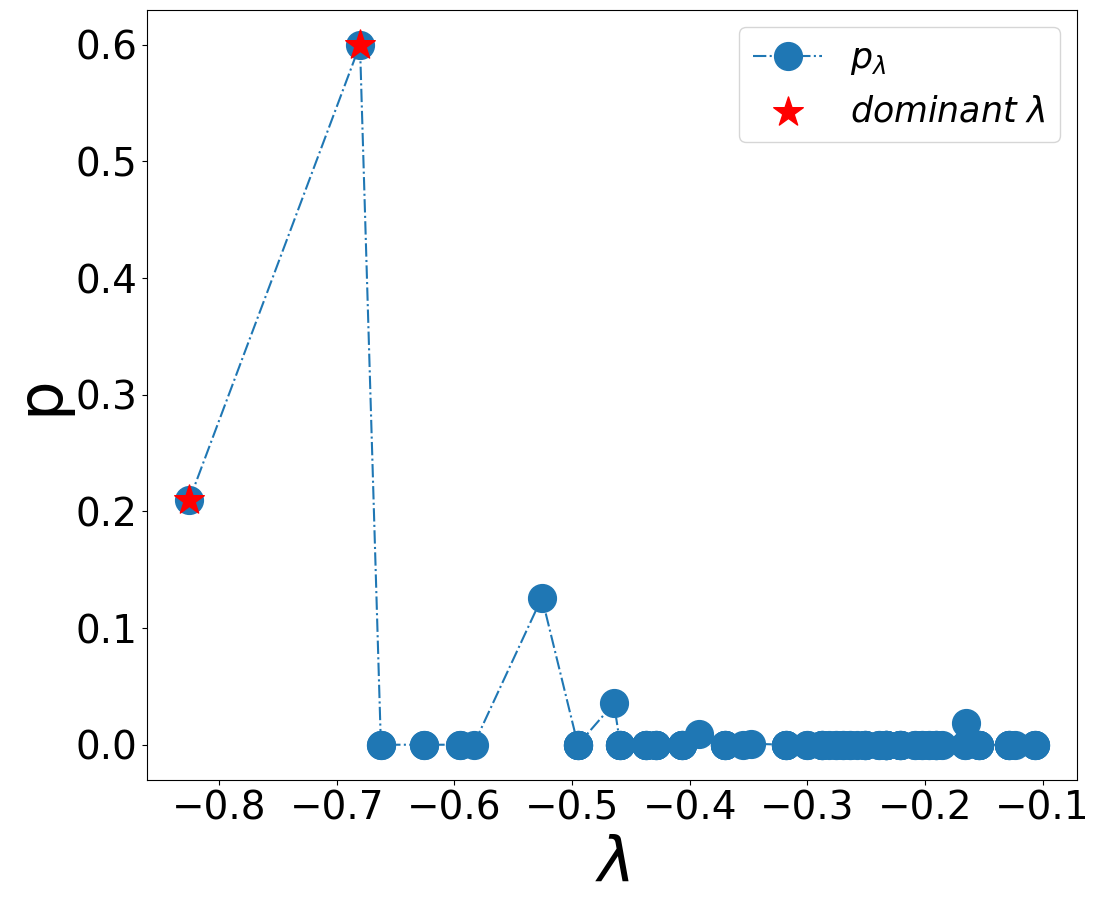

In [7]:
fig5=plt.figure(figsize=(12,10))
plt.plot(spectrum,population,linestyle="-.",marker="o",markersize=20,
         label="$p_{\lambda}$",zorder = 1)
plt.xlabel("$\lambda$",fontsize=45)
plt.ylabel("p",fontsize=45) 
plt.scatter([spectrum[0],spectrum[1]],
            [population[0],population[1]],label=r"$dominant\ \lambda$",marker="*",c ="red",zorder = 2,s=500)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=25)
plt.savefig('TFIM_eigendistribution_small_p_0.pdf')
plt.show()